<a href="https://colab.research.google.com/github/kessingtonosazee/GCP_Project_1/blob/master/aml_2324_w3_shap_pp_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SHAP Demo with Classification and PIMA Diabetes

* 6G7V0017 Advanced Machine Learning S2W3, Luciano Gerber

* We had a quick introduction of SHAP values in our lecture, which are particularly useful to understand the average effects that features have on predictions for a particular model.

* In this lab notebook, we will go through the practical side of it - we will use the `shap` package for obtaining and visualising the SHAP values for a random forest classifier on our usual PIMA Diabetes case study.

* I would like all to use this as inspiration for analysing another classification problem/dataset (e.g., `titanic`).

## Import Packages and Set Up Environment

* You'll need to install `shap` here.

In [1]:
# latest version of scikit-learn: might need a kernel restart
!pip install --upgrade scikit-learn==1.4.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 22.9 MB/s eta 0:00:00


In [2]:
import sklearn
# this makes is easier for getting dataframes by default as input/output of
# sklearn pipelines
sklearn.set_config(transform_output="pandas")

%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    { "figure.figsize": (6, 4) }, style='ticks', color_codes=True, font_scale=0.8
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer

In [3]:
# SHAP is not normally part of a standard Python distribution
# I am installing it here by asking the underlying operating system to
# `pip install` the package (`-q` for a quiet output)
!pip install --upgrade shap==0.44.1 -q
import shap
shap.initjs()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 6.1 MB/s eta 0:00:00


## Load, Inspect, Prepare Data

* we have the diabetes data into the usual `X_train, y_train, X_test, y_test` split.

In [4]:
diabetes = pd.read_csv(
    'https://raw.githubusercontent.com/gerberl/6G7V0017-2324/main/datasets/diabetes.csv'
)
diabetes.head(1)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1


In [5]:
diabetes['Outcome']

0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 768, dtype: int64

In [7]:
X, y = diabetes.drop(columns='Outcome'), diabetes['Outcome']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, stratify=y
)   # stratify is used to preserve the distribution of the target set in both the training and test data sets.

## Fit and Inspect a Random Forest (to be explained by SHAP)

* the output of this stage is a classifier pipeline `clf` containing pre-processing (`pp`) and classifier (`est`) stages; the classifier is a typical Random Forest.

In [8]:
X.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [9]:
# `Pregnancies` is the only column that we could accept 0s as valid measurements
# For the other columns, we assume that 0s mean "missing"
cols_cannot_be_0 = X.columns.drop(['Pregnancies']).tolist()
cols_cannot_be_0

['Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [10]:
"""
A classifier pipeline composed of two steps:

* `pp` is a ColumnTransformer for pre-processing the data. Here, it applies
a SimpleImputer to replace 0s by the mean. It excludes `Pregnancies`, as 0s
would have been valid, which is just passed through.

* `est` is the classifier (estimator); as usual, we are relying on a
Random Forest classifier with a typical configuration.
"""
clf = Pipeline(steps=[
    ('pp', ColumnTransformer(
        [
            ('imputer',
             SimpleImputer(missing_values=0, strategy="mean"),
             cols_cannot_be_0)
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    )),
    ('est', RandomForestClassifier(
        max_depth=8, min_samples_split=15, min_samples_leaf=8, n_estimators=400
    ))
])
clf.fit(X_train, y_train)

Pipeline(steps=[('pp',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputer',
                                                  SimpleImputer(missing_values=0),
                                                  ['Glucose', 'BloodPressure',
                                                   'SkinThickness', 'Insulin',
                                                   'BMI',
                                                   'DiabetesPedigreeFunction',
                                                   'Age'])],
                                   verbose_feature_names_out=False)),
                ('est',
                 RandomForestClassifier(max_depth=8, min_samples_leaf=8,
                                        min_samples_split=15,
                                        n_estimators=400))])

In [11]:
# for sanity check
eval_results = cross_validate(
    clf, X, y, cv=5, scoring='balanced_accuracy', return_train_score=True
)
test_scores = eval_results['test_score']
train_scores = eval_results['train_score']
(test_scores.mean(), test_scores.std()), (train_scores.mean(), train_scores.std())

((0.7121271837875611, 0.03721676579480688),
 (0.829211910454249, 0.00535287950721364))

In [12]:
def plot_est_feat_imp_barh(est, feat_names, ax=None, top_feat_k=10, style_kws={}):
    """ """
    if ax is None:
        fig, ax = plt.subplots()

    return pd.Series(
        est.feature_importances_,
        index=feat_names
    ).sort_values().tail(top_feat_k).plot.barh(**style_kws)

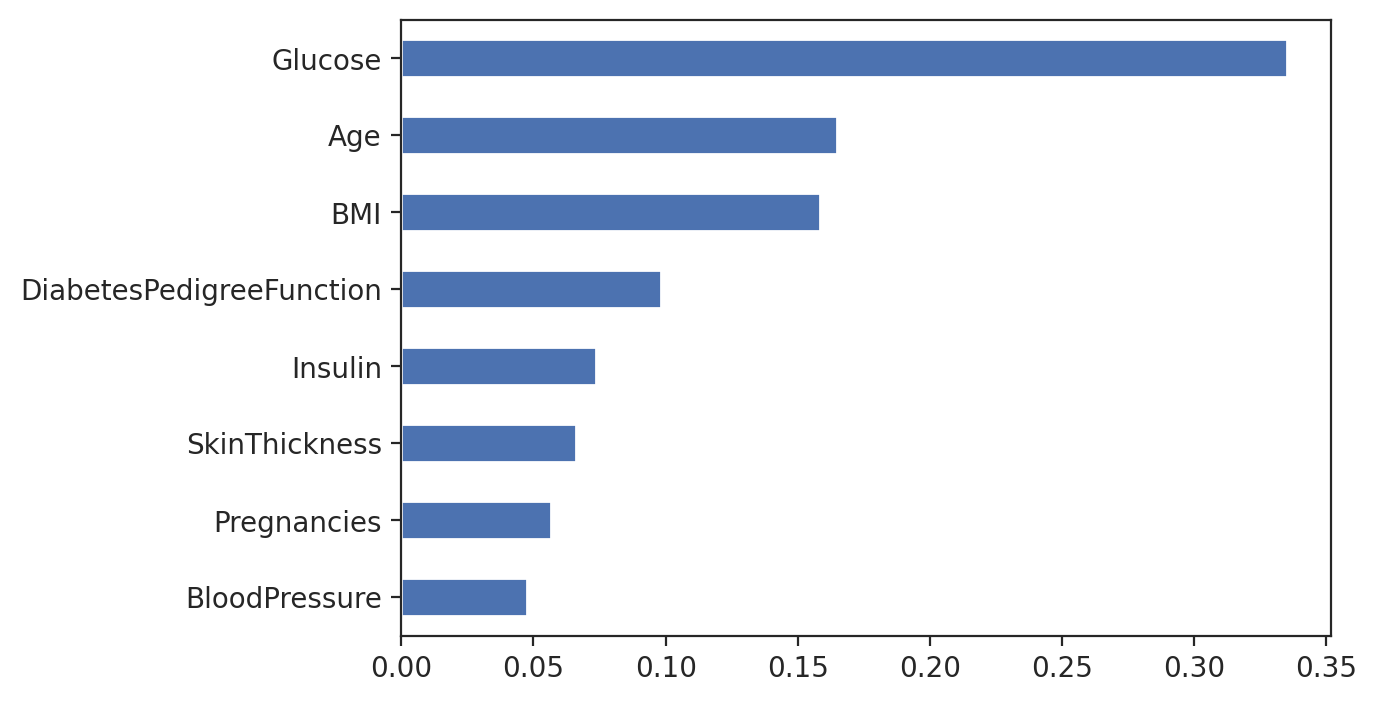

In [13]:
plot_est_feat_imp_barh(clf['est'], clf['pp'].get_feature_names_out());

## SHAP Explainer and Local Explanations

In [14]:
# Not ideal, perhaps, but currently it makes life easier if one pre-processes
# the data used for SHAP computations
X_train_pp = clf['pp'].transform(X_train)
column_names = X_train_pp.columns
X_test_pp  = clf['pp'].transform(X_test)

In [15]:
# this instantiates an Explainer object for global and local explanations
# on the Random Forest Model. (don't worry about `check_addditivity`).
# It takes the classifier (the `est` in our pipeline) and the background
# data in `X_train` to obtain, for example, the base case statistics
explainer = shap.Explainer(clf['est'], X_train_pp)

In [39]:
# creates a TreeExplainer by default (based on the model passed)
explainer

In [40]:
# just checking what the data looks like after pre-processing
X_train_pp.head(1)

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Pregnancies
432,80.0,74.0,11.0,60.0,30.0,0.527,22.0,1


In [18]:
X_test_pp.head(1)

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Pregnancies
147,106.0,64.0,35.0,119.0,30.5,1.4,34.0,2


In [19]:
# Here is where the explanations (the SHAP values, really) are generated on the
# test data
explanations = explainer(X_test_pp, check_additivity=False)

In [20]:
# see what type of Python object it is
type(explanations)

shap._explanation.Explanation

In [21]:
# `explanations` is a 3D array
# 3rd dimension is the class value (0, 1 here for binary classification)
# 1st: observation (row) index
# 2nd: feature (column) index
explanations.shape

(192, 8, 2)

In [22]:
# Let us have a look at the feature effect assignments to a single prediction
# Assume we would like to investigate the positive class (has diabetes)
cls_idx = 1
# we can investigate a local explanation (positional index is 0)
row_idx = 0

In [23]:
cls_idx, row_idx

(1, 0)

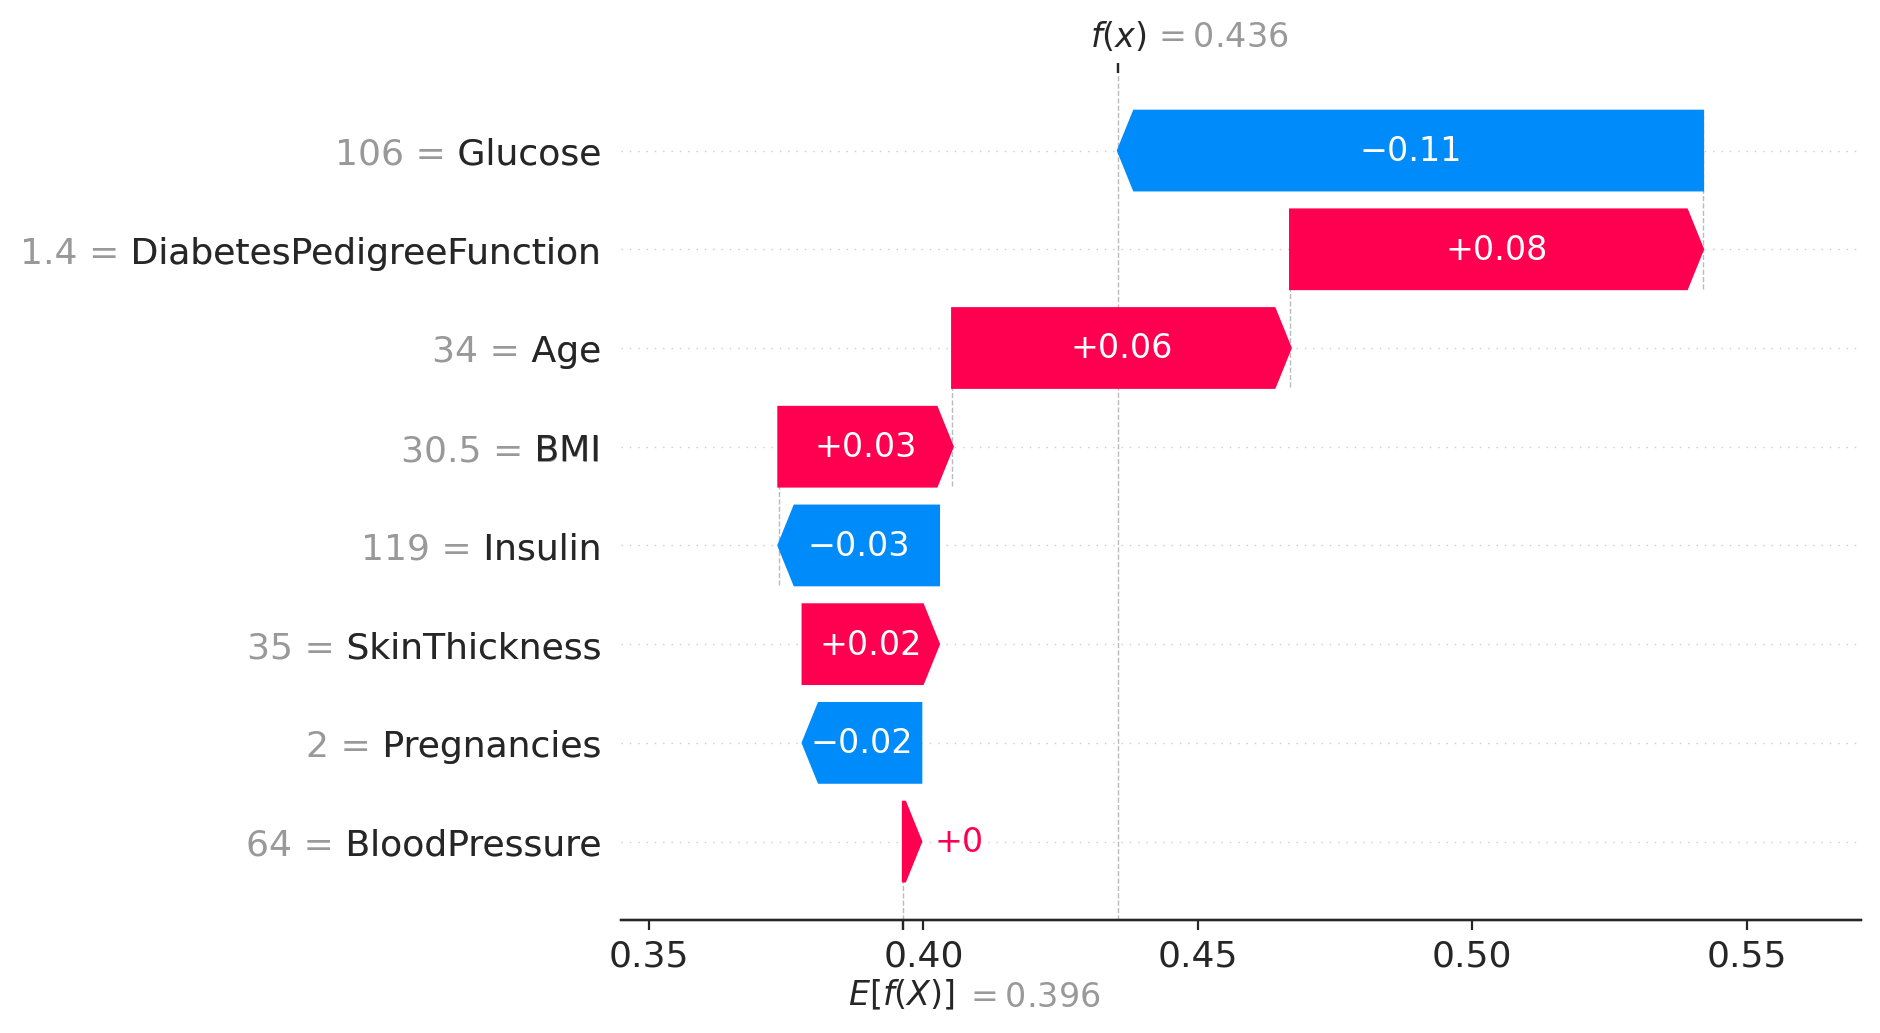

In [24]:
shap.plots.waterfall(explanations[row_idx, :, cls_idx])

In [25]:
shap.initjs()
shap.plots.force(explanations[row_idx, :, cls_idx])

In [26]:
# this is the test observation we are using (explained in the plots above)
X_test.iloc[[row_idx]][column_names]

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Pregnancies
147,106,64,35,119,30.5,1.4,34,2


In [27]:
# this is the hard prediction for this observation by the Random Forest
clf.predict(X_test.iloc[[row_idx]][column_names])

array([0])

In [28]:
# ...and this is the probabilistic prediction by that Random Forest
clf.predict_proba(X_test.iloc[[row_idx]][column_names])

array([[0.56439204, 0.43560796]])

## SHAP Values and Global Explanations

In [29]:
# we can ask the explainer for the SHAP values on the test data
shap_values = explainer.shap_values(X_test_pp, check_additivity=False)

 99%|===================| 380/384 [00:11<00:00]       

In [30]:
# SHAP values: for binary classification with Random Forests, it is a 3D-array
# (actually, a list of 2D-arrays)
# 1st dimension is the class value (0, 1)
# 2nd: observation (row) index
# 3rd: feature (column) index
len(shap_values), shap_values[0].shape

(2, (192, 8))

In [31]:
type(shap_values)

list

In [32]:
# great thingy about SHAP values: it is just data!
# I can manipulate it, join them with the train/test data, summarise it,
# and so on
shap_values_df = pd.DataFrame(
    shap_values[cls_idx], columns=column_names, index=X_test.index
)

In [33]:
shap_values_df.head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Pregnancies
147,-0.106510,0.003222,0.024726,-0.029147,0.031666,0.075133,0.061585,-0.021499
565,-0.124172,-0.016698,-0.042024,-0.035410,-0.083483,0.039970,-0.066870,-0.017628
390,-0.139986,0.016329,-0.015413,0.028887,0.033818,-0.008033,0.101022,-0.007644
736,-0.001017,-0.004167,-0.042349,-0.011877,-0.056624,-0.000367,-0.121191,-0.026191
587,-0.111944,0.005453,-0.003653,0.002712,-0.136330,-0.023710,-0.028683,0.004178


In [34]:
X_test[column_names].head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Pregnancies
147,106,64,35,119,30.5,1.400,34,2
565,95,54,14,88,26.1,0.748,22,2
390,100,66,29,196,32.0,0.444,42,1
736,126,86,27,120,27.4,0.515,21,0
587,103,66,0,0,24.3,0.249,29,6


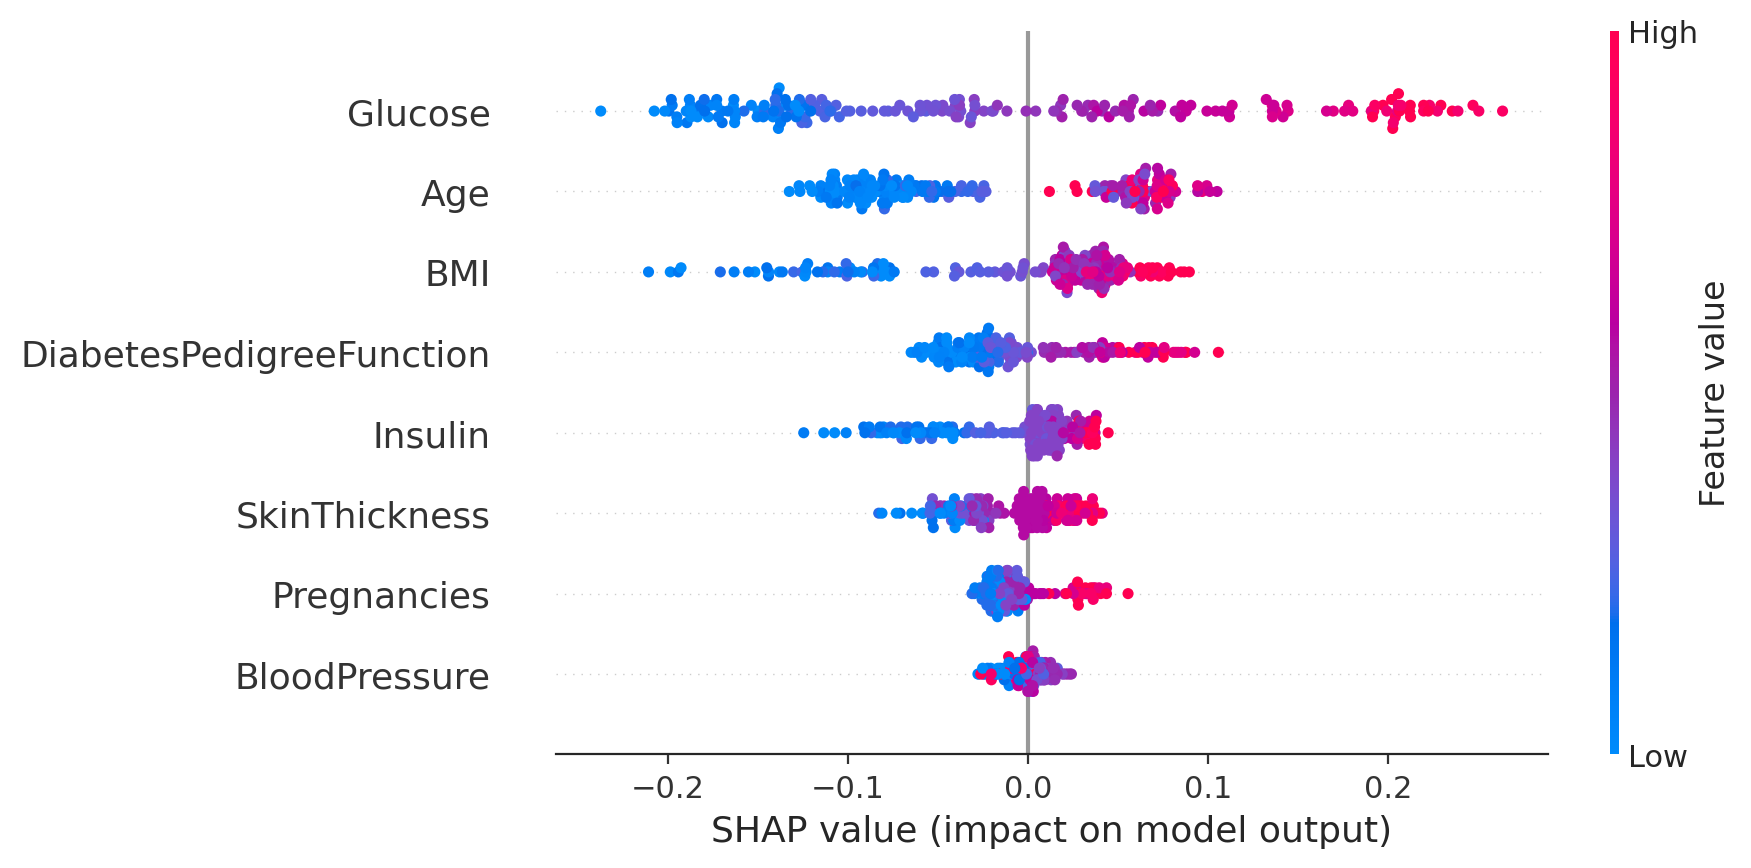

In [35]:
# that global SHAP plot we discussed in the lecture
# color is the feature value
# each row corresponds to a different feature, represented by a stripplot
# the x values are the SHAP values
# each data point is an observation of the test data

# look at magnitude of SHAP effect, correlation of colours and polarity,
# ranking of features
shap.plots.beeswarm(explanations[:,:,cls_idx])

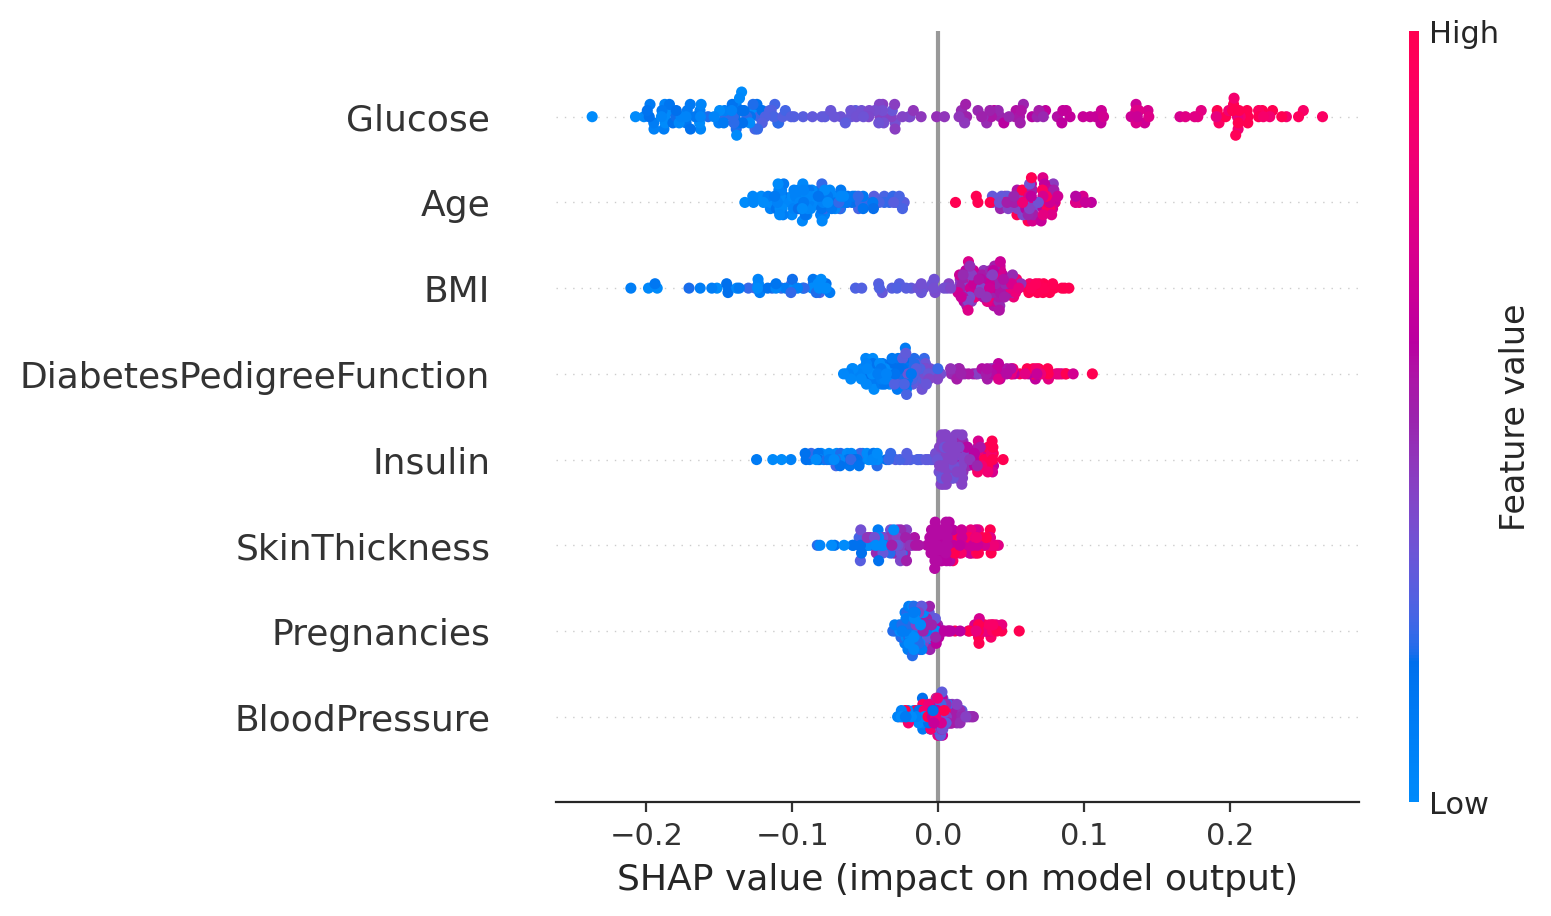

In [36]:
# same as above
shap.summary_plot(explanations[:,:,cls_idx])

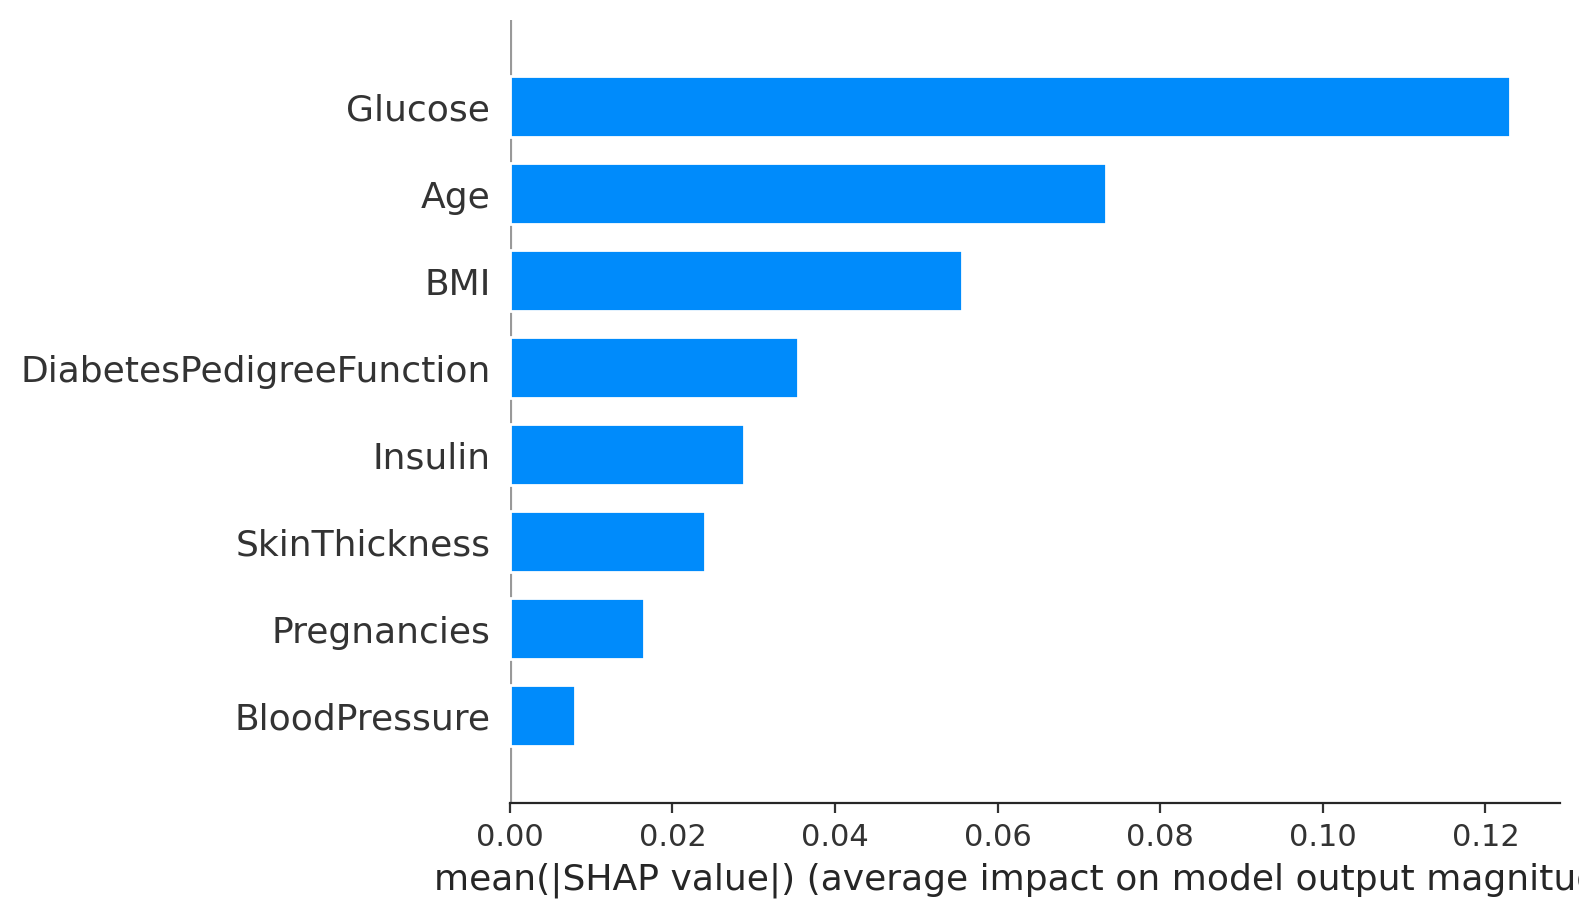

In [37]:
# a global explanation: mean absolute SHAP as feature importance
shap.summary_plot(explanations[:,:,cls_idx], plot_type="bar")

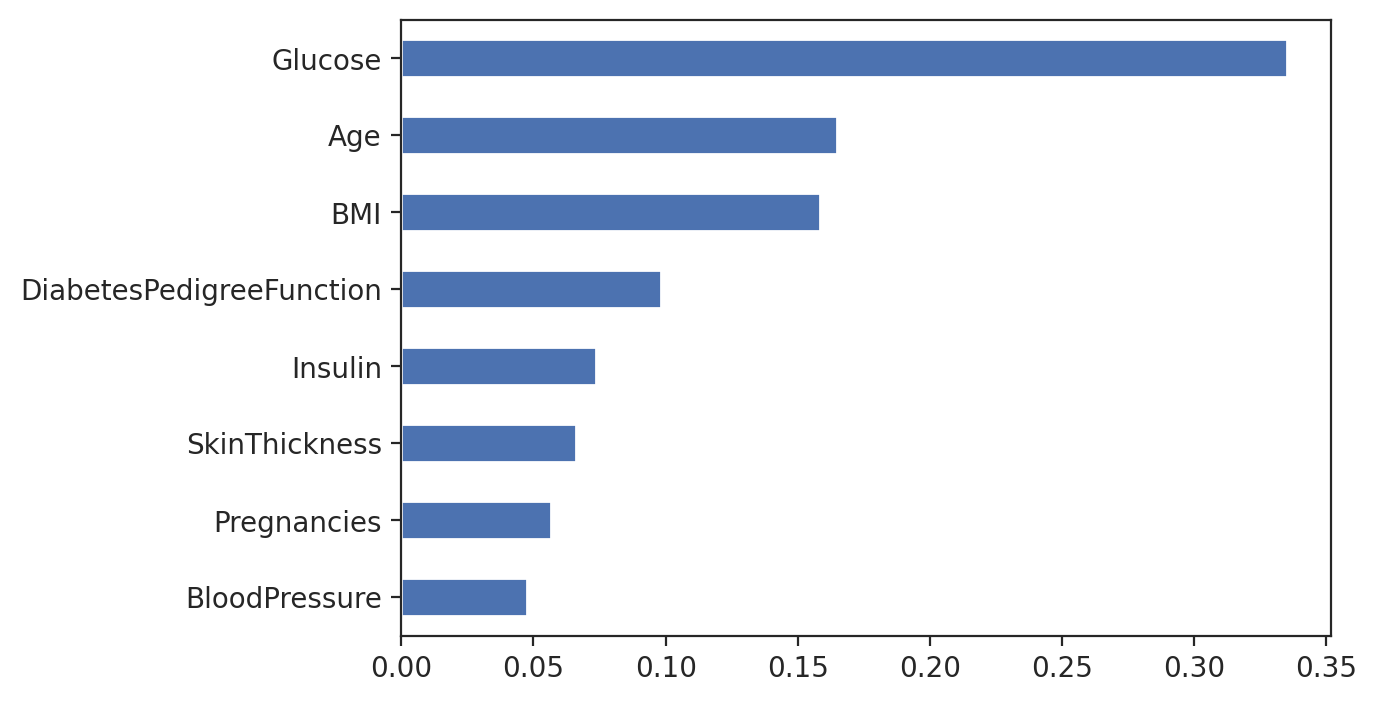

In [38]:
# compare the above to our usual model-specific feature importance
plot_est_feat_imp_barh(clf['est'], clf['pp'].get_feature_names_out());